In [71]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

%matplotlib inline

In [72]:
def convert_to_float(value):        
    if "K" in value:
        return float(value[:-1]) * 1000
    if "M" in value:
        return float(value[:-1]) * 1000000
    if "B" in value:
        return float(value[:-1]) * 1000000000
    if "%" in value:
        return float(value[:-1]) / 100
    if value == "-":
        return None
    if "," in value:
        return float(value.replace(",", ""))
    return float(value)

In [73]:
def plot(data_label_pairs, x_label, y_label, title):
    plt.figure(figsize=(6.40, 3.60), dpi=200)
    for data, label in data_label_pairs:
        plt.plot(data, label=label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=15)
    plt.show()

In [74]:
def test_stationarity(data):
    print("Dicky Fuller Test Results:")
    results = adfuller(data, autolag="AIC")
    output = pd.Series(results[:4], index=["Statistics", "p-value", "Lags", "Observations"]).append(pd.Series({"Critical Value (%s)" % key: value for key, value in results[4].items()}))
    print(output)
    if results[1] < 0.05:
        print("Data Is Stationary.")
    else:
        print("Data Is Not Stationary.")

In [75]:
def performance(actual, predicted):
    print("Performance:")
    mse = mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    r2 = r2_score(actual, predicted)
    print("mean squared error: ", mse)
    print("root mean square error: ", rmse)
    print("mean absolute error: ", mae)
    print("mean absolute percentage error: ", mape, "%")
    print("r^2: ", r2)

In [76]:
ether_data = pd.read_csv("Datasets/ETH-USD-Data.csv")
ether_data.rename(columns={"Price": "Close", "Vol.": "Volume", "Change %": "Change"}, inplace=True)
ether_data["Date"] = ether_data['Date'].astype("datetime64")
for column in ether_data.columns[1:]:
    ether_data[column] = ether_data[column].apply(convert_to_float)
ether_data = ether_data.reindex(columns=["Date", "Open", "High", "Low", "Close", "Volume", "Change"]).set_index("Date").sort_values("Date")
ether_data = ether_data.interpolate()
dates = list(ether_data.index)

In [77]:
ether_data

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2016-03-10,11.20,11.85,11.07,11.75,0.0,0.0491
2016-03-11,11.75,11.95,11.75,11.95,180.0,0.0170
2016-03-12,11.95,13.45,11.95,12.92,830.0,0.0812
2016-03-13,12.92,15.07,12.92,15.07,1300.0,0.1664
2016-03-14,15.07,15.07,11.40,12.50,92180.0,-0.1705
...,...,...,...,...,...,...
2022-05-12,2087.17,2190.51,1796.24,1955.36,2840000.0,-0.0603
2022-05-13,1955.59,2146.22,1941.53,2009.53,1340000.0,0.0277
2022-05-14,2009.55,2068.66,1952.07,2056.30,656940.0,0.0233


In [78]:
ether_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2259 entries, 2016-03-10 to 2022-05-16
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2259 non-null   float64
 1   High    2259 non-null   float64
 2   Low     2259 non-null   float64
 3   Close   2259 non-null   float64
 4   Volume  2259 non-null   float64
 5   Change  2259 non-null   float64
dtypes: float64(6)
memory usage: 123.5 KB


In [79]:
ether_data.describe()

,Open,High,Low,Close,Volume,Change
count,2259.000000,2259.000000,2259.000000,2259.000000,2.259000e+03,2259.000000
mean,816.945573,845.670832,783.999934,817.810164,1.319516e+07,0.003885
std,1163.714564,1200.428925,1120.644492,1163.846004,1.035528e+08,0.056125
min,6.680000,7.320000,5.860000,6.700000,0.000000e+00,-0.445500
25%,135.530000,139.740000,130.825000,135.625000,5.344550e+05,-0.022300
50%,259.920000,269.770000,245.750000,261.540000,1.480000e+06,0.001100
75%,784.640000,830.525000,736.040000,786.085000,7.930000e+06,0.029450
max,4808.340000,4864.060000,4715.430000,4808.380000,1.790000e+09,0.295100


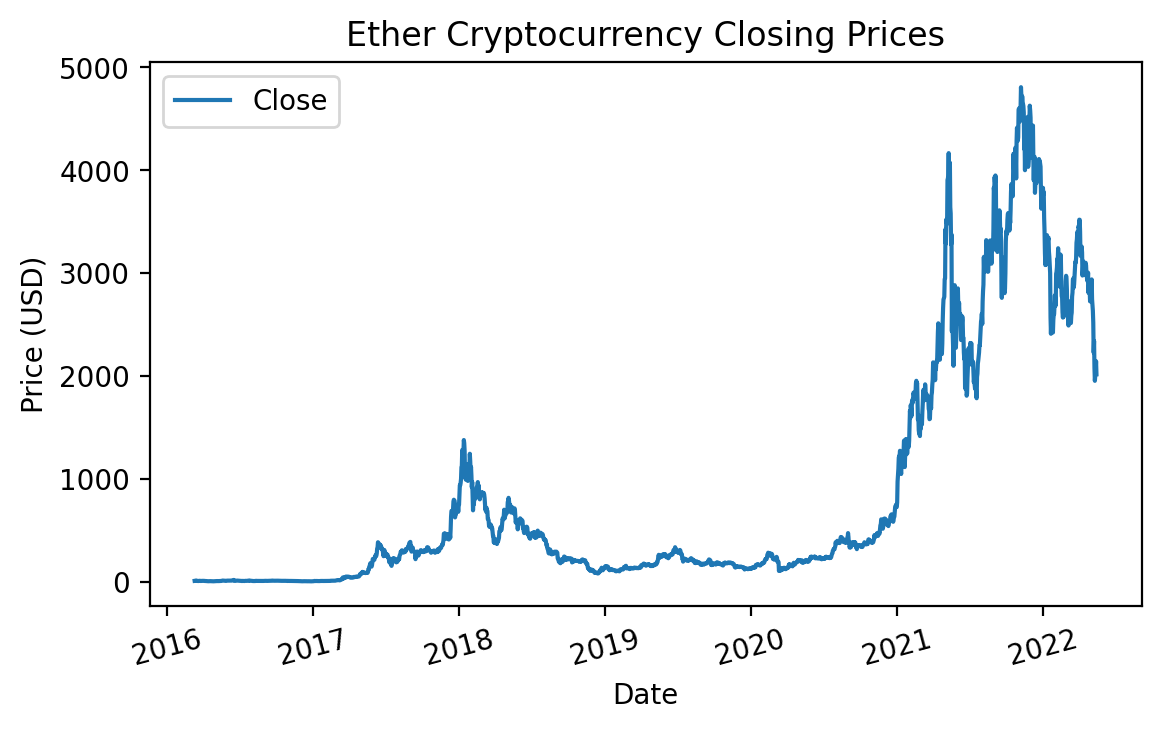

In [80]:
plot(data_label_pairs=[(ether_data["Close"], "Close")], x_label="Date", y_label="Price (USD)", title="Ether Cryptocurrency Closing Prices")

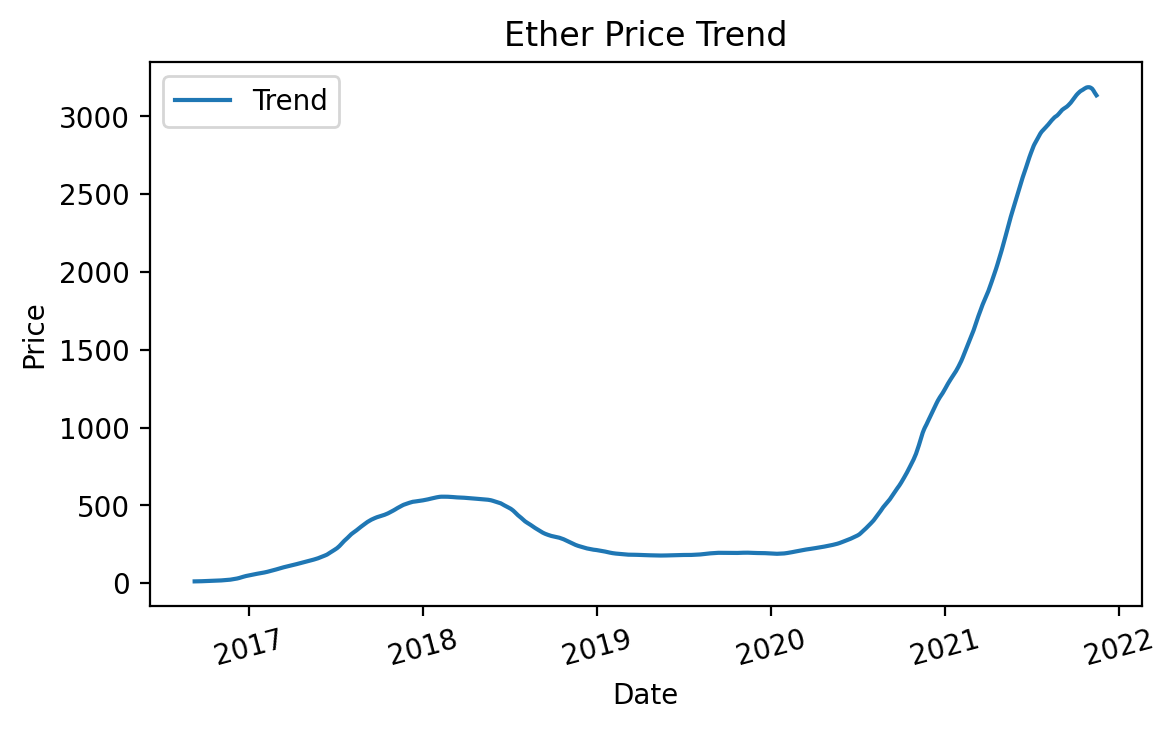

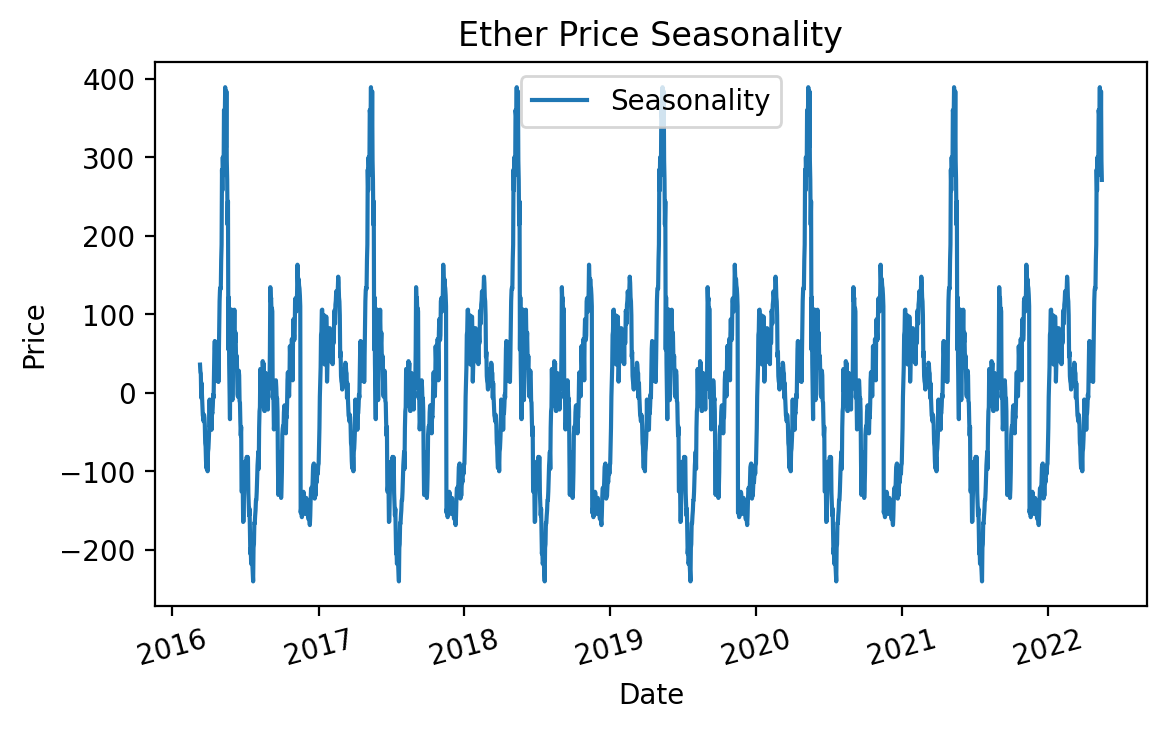

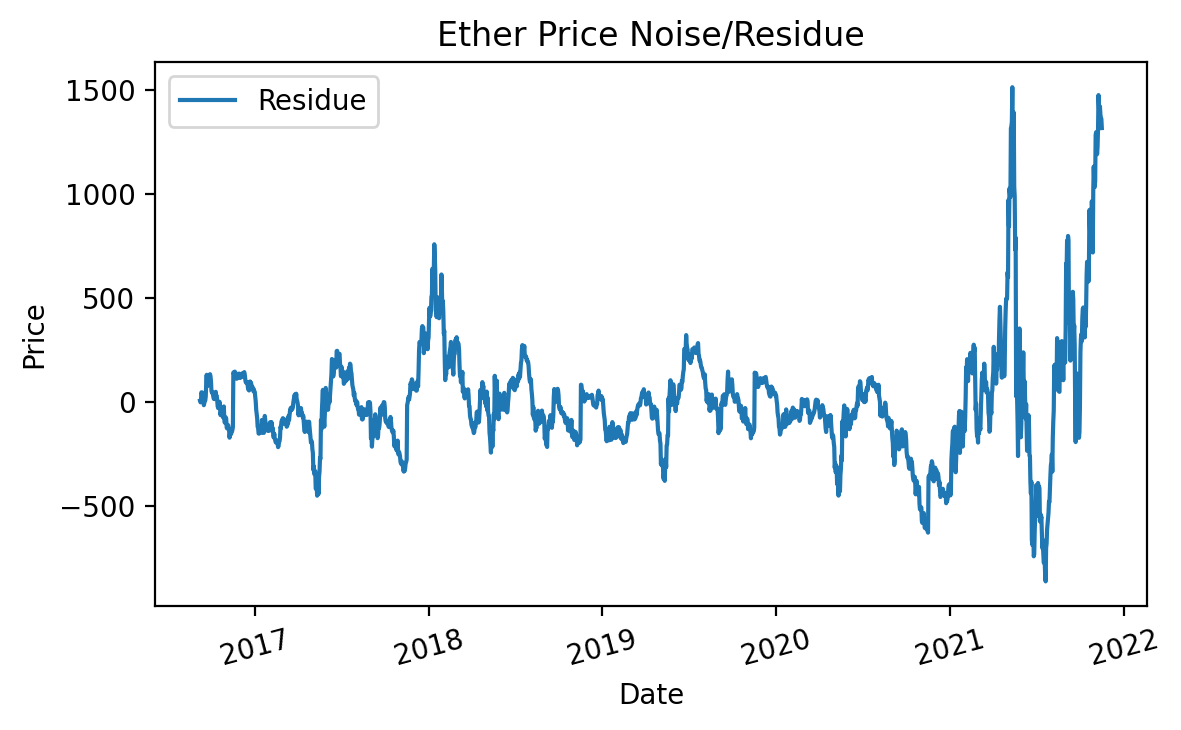

In [81]:
decomposition = seasonal_decompose(ether_data["Close"], model="additive", period=365)
plot([(decomposition.trend, "Trend")], "Date", "Price", "Ether Price Trend")
plot([(decomposition.seasonal, "Seasonality")], "Date", "Price", "Ether Price Seasonality")
plot([(decomposition.resid, "Residue")], "Date", "Price", "Ether Price Noise/Residue")

In [82]:
test_stationarity(ether_data["Close"])

Dicky Fuller Test Results:
Statistics                -1.177267
p-value                    0.683298
Lags                      17.000000
Observations            2241.000000
Critical Value (1%)       -3.433271
Critical Value (5%)       -2.862831
Critical Value (10%)      -2.567457
dtype: float64
Data Is Not Stationary.


C:\Users\samee\AppData\Local\Temp\ipykernel_13248\2946238253.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = pd.Series(results[:4], index=["Statistics", "p-value", "Lags", "Observations"]).append(pd.Series({"Critical Value (%s)" % key: value for key, value in results[4].items()}))


In [83]:
ether_data_arima = pd.DataFrame(ether_data["Close"], columns=["Close"])

In [84]:
ether_data_arima

,Close
Date,
2016-03-10,11.75
2016-03-11,11.95
2016-03-12,12.92
2016-03-13,15.07
2016-03-14,12.50
...,...
2022-05-12,1955.36
2022-05-13,2009.53
2022-05-14,2056.30


In [85]:
first_diff = pd.DataFrame(ether_data_arima["Close"].diff().dropna()).rename(columns={"Close": "1st_Difference"})

In [86]:
first_diff

,1st_Difference
Date,
2016-03-11,0.20
2016-03-12,0.97
2016-03-13,2.15
2016-03-14,-2.57
2016-03-15,0.56
...,...
2022-05-12,-125.43
2022-05-13,54.17
2022-05-14,46.77


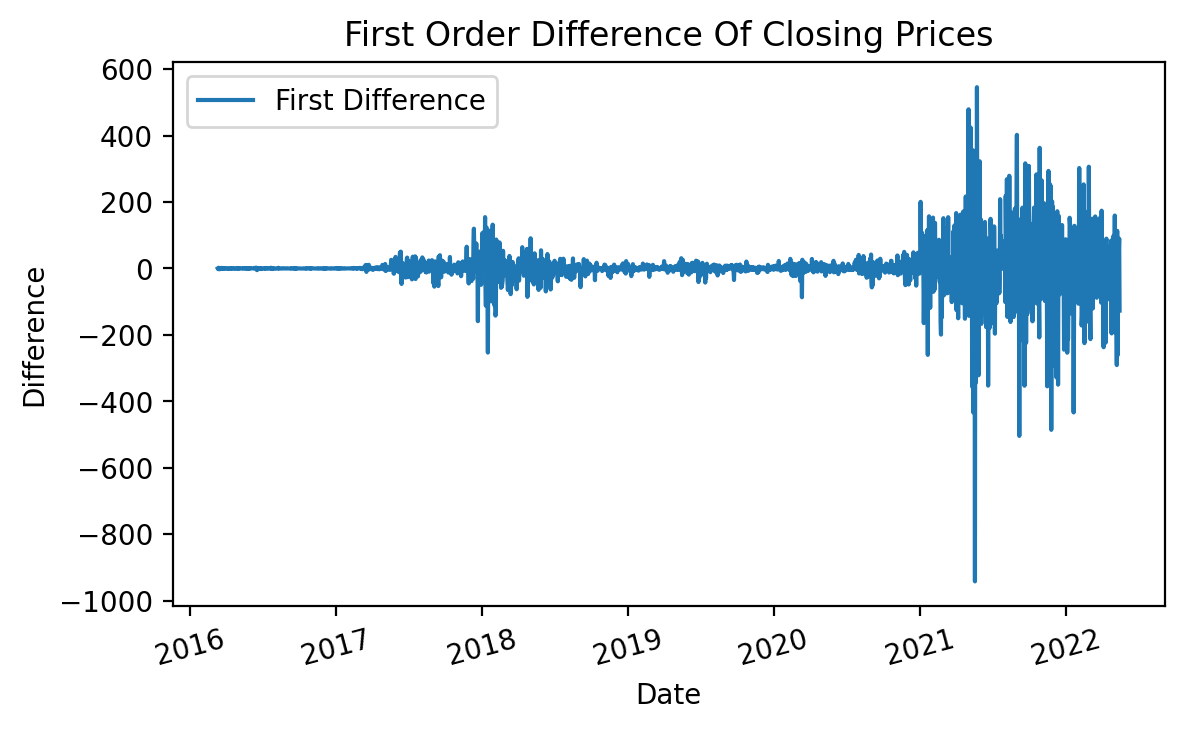

In [87]:
plot(data_label_pairs=[(first_diff["1st_Difference"], "First Difference")], x_label="Date", y_label="Difference", title="First Order Difference Of Closing Prices")

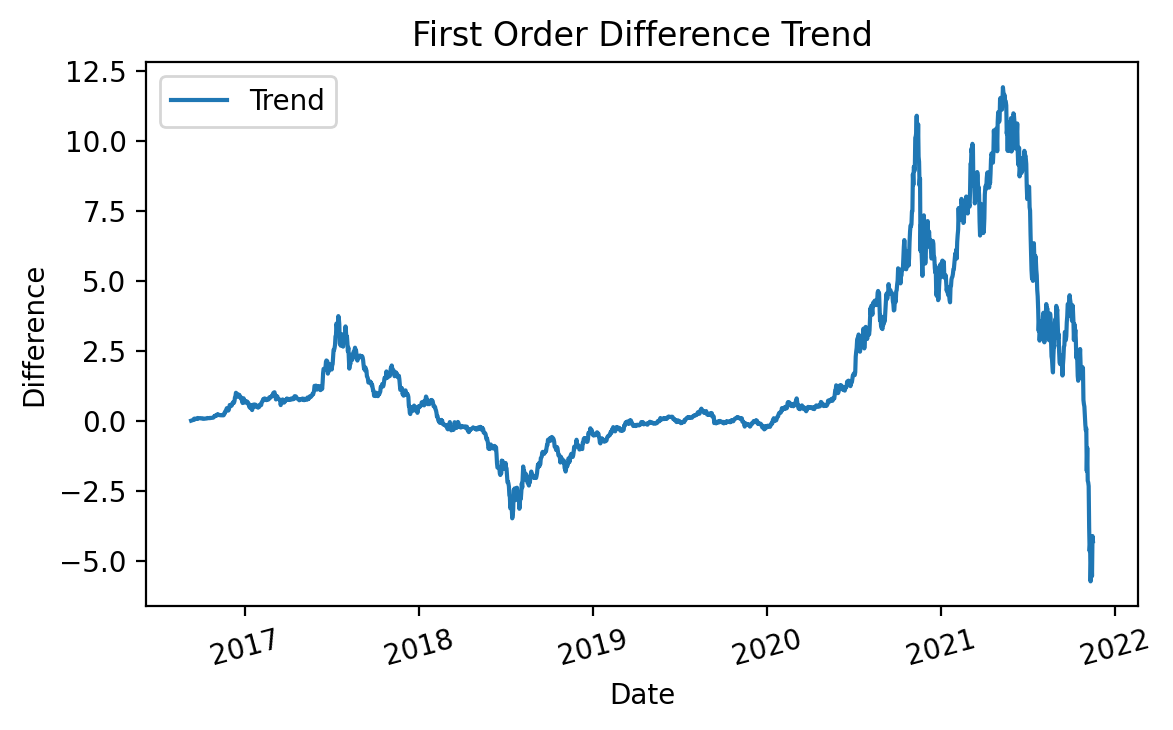

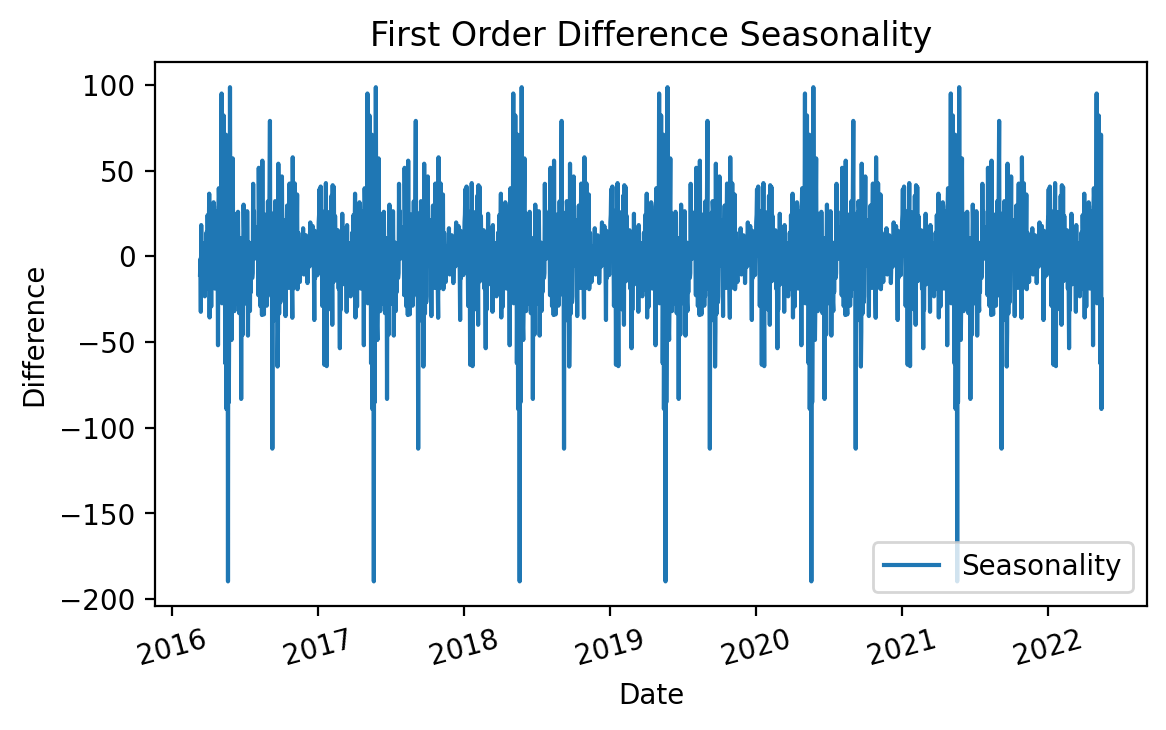

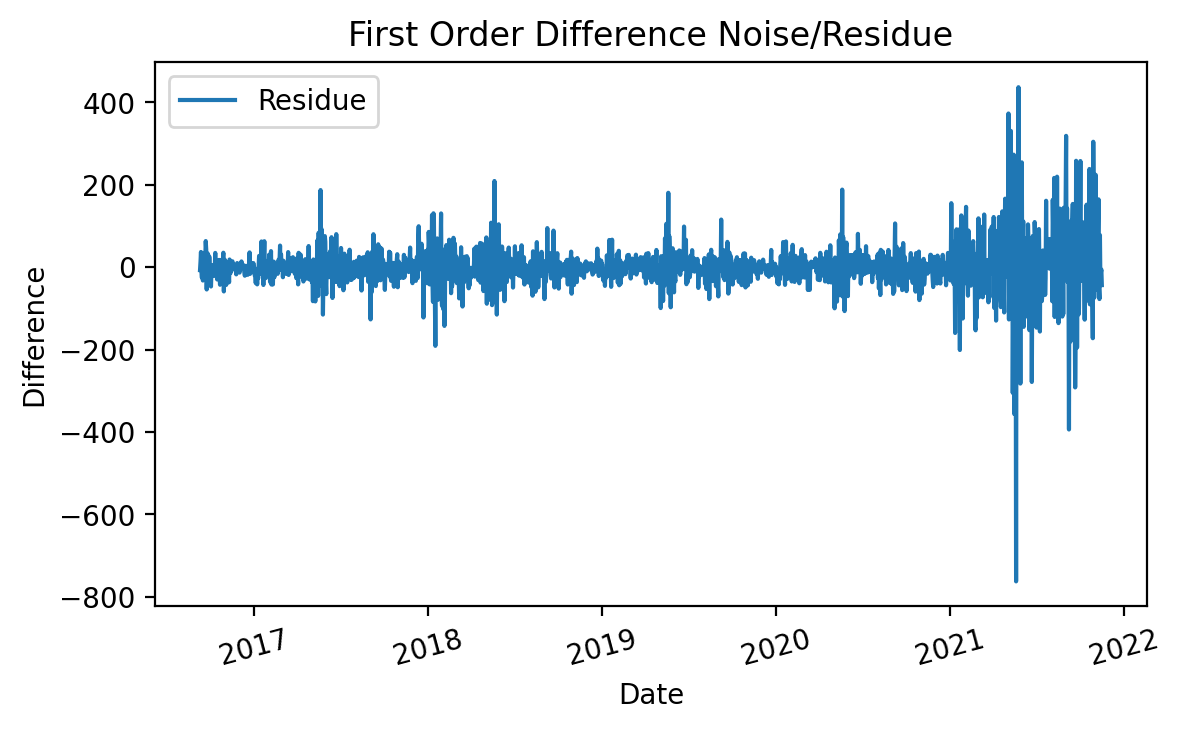

In [88]:
decomp_first_diff = seasonal_decompose(first_diff["1st_Difference"], model="additive", period=365)
plot([(decomp_first_diff.trend, "Trend")], "Date", "Difference", "First Order Difference Trend")
plot([(decomp_first_diff.seasonal, "Seasonality")], "Date", "Difference", "First Order Difference Seasonality")
plot([(decomp_first_diff.resid, "Residue")], "Date", "Difference", "First Order Difference Noise/Residue")

In [89]:
test_stationarity(first_diff["1st_Difference"])

Dicky Fuller Test Results:
Statistics             -7.850523e+00
p-value                 5.617246e-12
Lags                    2.700000e+01
Observations            2.230000e+03
Critical Value (1%)    -3.433286e+00
Critical Value (5%)    -2.862837e+00
Critical Value (10%)   -2.567460e+00
dtype: float64
Data Is Stationary.


C:\Users\samee\AppData\Local\Temp\ipykernel_13248\2946238253.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = pd.Series(results[:4], index=["Statistics", "p-value", "Lags", "Observations"]).append(pd.Series({"Critical Value (%s)" % key: value for key, value in results[4].items()}))


In [90]:
pacf = pacf(first_diff["1st_Difference"], nlags=20, method="ols")
acf = acf(first_diff["1st_Difference"], nlags=20)

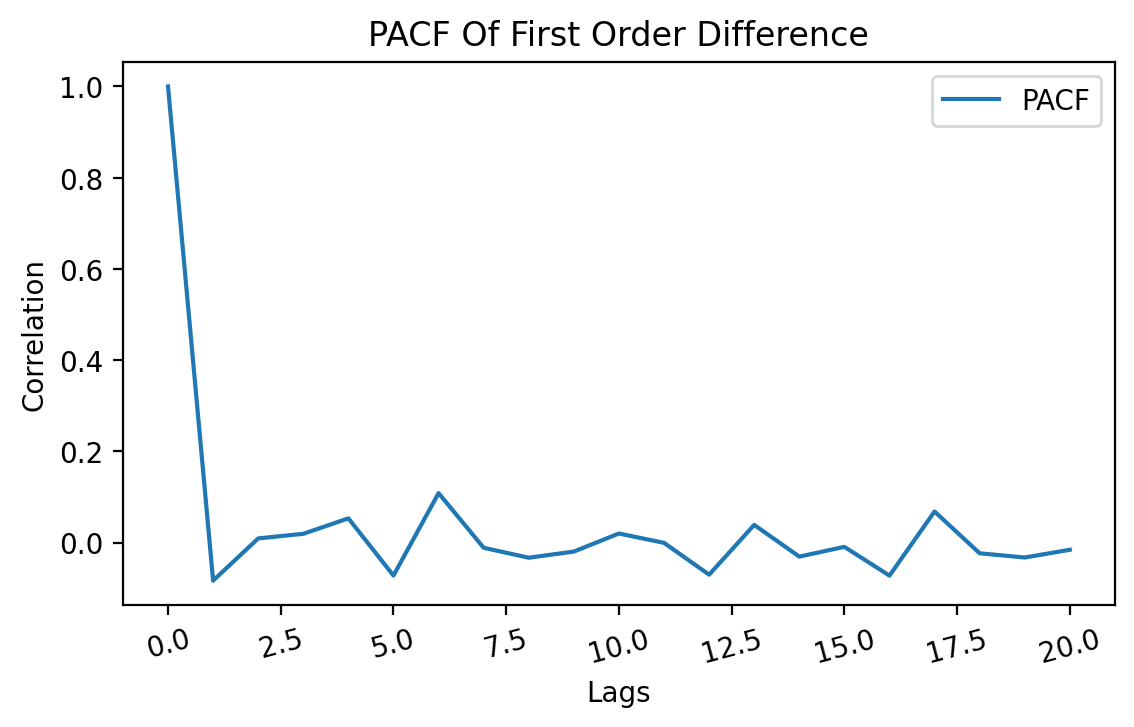

In [91]:
plot(data_label_pairs=[(pacf, "PACF")], x_label="Lags", y_label="Correlation", title="PACF Of First Order Difference")

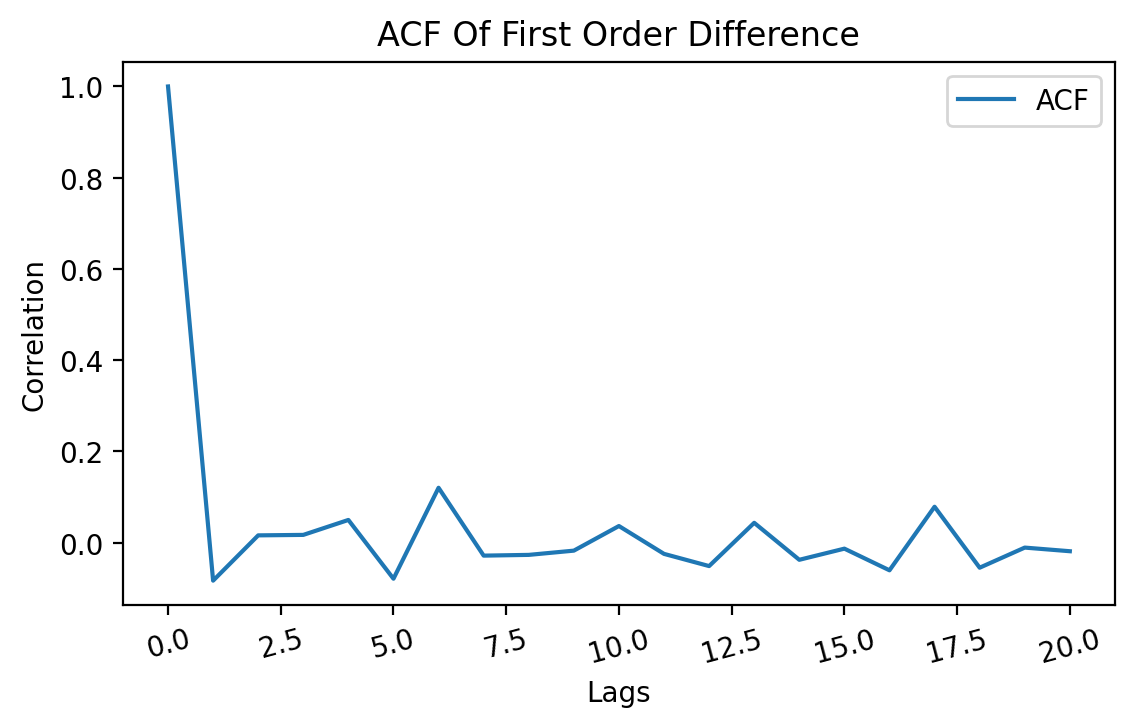

In [92]:
plot(data_label_pairs=[(acf, "ACF")], x_label="Lags", y_label="Correlation", title="ACF Of First Order Difference")

In [93]:
training_size = int(len(ether_data_arima["Close"]) * 0.80)
test_size = len(ether_data_arima["Close"]) - training_size
train_ether_data = ether_data_arima[:training_size]
test_ether_data = ether_data_arima[training_size:]

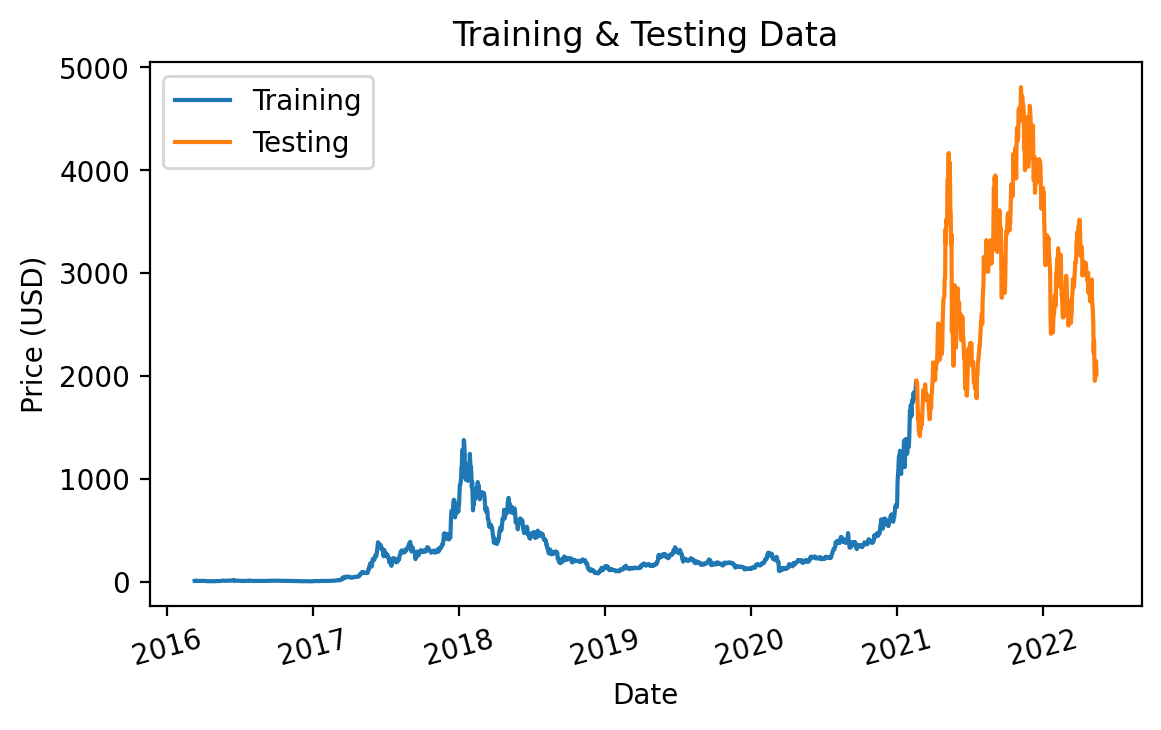

In [94]:
plot(data_label_pairs=[(train_ether_data["Close"], "Training"), (test_ether_data["Close"], "Testing")], x_label="Date", y_label="Price (USD)", title="Training & Testing Data")

In [286]:
arima_model = ARIMA(train_ether_data["Close"], order=(4,1,2))
fitted_arima = arima_model.fit()
fitted_arima.summary()

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\statsm

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1807
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -8366.308
Date:                Sat, 21 May 2022   AIC                          16746.616
Time:                        13:17:24   BIC                          16785.109
Sample:                    03-10-2016   HQIC                         16760.823
                         - 02-18-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1437      0.042      3.407      0.001       0.061       0.226
ar.L2          0.7930      0.043     18.588      0.000       0.709       0.877
ar.L3         -0.0193      0.009     -2.115      0.034      -0.037      -0.001
ar.L4          0.0677      0.010      6.551      0.000       0.047       0.088
ma.L1         -0.1379      0.043     -3.229      0.001      -0.222      -0.054
ma.L2         -0.8165      0.043    -18.863      0.000      -0.901      -0.732
sigma2       618.2864      6.001    103.036      0.000     606.525     630.047
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             50044.37
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               8.21   Skew:                            -0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [287]:
predicted = fitted_arima.forecast(90, alpha=0.05)

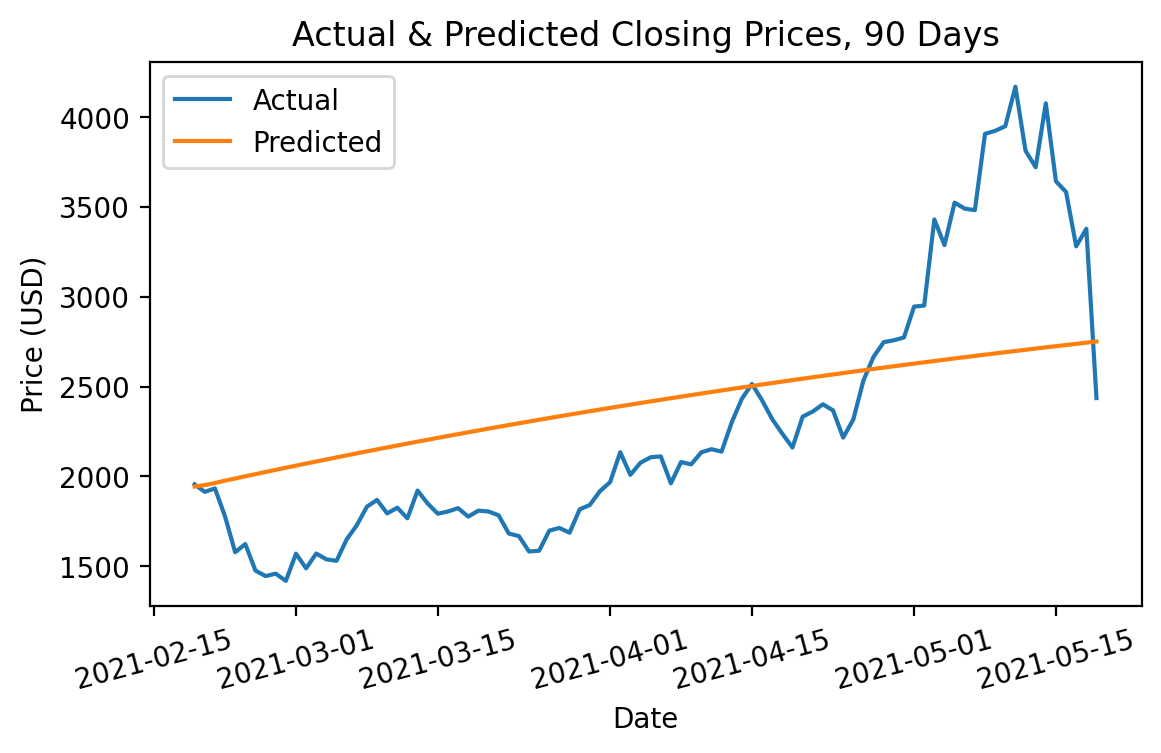

In [288]:
plot(data_label_pairs=[(test_ether_data["Close"][:90], "Actual"), (predicted[:90], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual & Predicted Closing Prices, 90 Days")

In [289]:
performance(test_ether_data["Close"][:90], predicted[:90])

Performance:
mean squared error:  315033.83931179455
root mean square error:  561.2787536614891
mean absolute error:  471.27515686035895
mean absolute percentage error:  21.160476890456174 %
r^2:  0.4137595102926349
